# Importing and setting up

In [1]:
import fastbook
fastbook.setup_book()

In [2]:
from fastai.vision.all import *
from fastbook import *
matplotlib.rc('image', cmap='viridis')

In [3]:
from pathlib import Path
import os, kaggle

isKaggle = os.getenv('KAGGLE_KERNEL_RUN_TYPE', '')
if isKaggle:
    path = Path('../input/intel-image-classification ')
    !pip install -Uqq fastai
else:
    import zipfile, fastai
    path= Path('intel-image-classification')
    # !kaggle datasets download -d puneet6060/intel-image-classification
    # kaggle.api.dataset_download_cli('puneet6060/intel-image-classification', unzip=True)
    # zipfile.ZipFile(f'{path}.zip').extractall(path)

# Data Split

In [4]:
train = path/'seg_train'
valid = path/'seg_test'
train.ls(), valid.ls()

((#1) [Path('intel-image-classification/seg_train/seg_train')],
 (#1) [Path('intel-image-classification/seg_test/seg_test')])

In [5]:
Image.open(get_image_files(path)[0]).shape

(150, 150)

In [6]:
len(get_image_files(train)), len(get_image_files(valid))

(14034, 3000)

In [7]:
# Creating DataLoader
imageBlock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                     get_items=get_image_files, #get files recursively in the dataloader
                     splitter=GrandparentSplitter(train_name='seg_train', valid_name='seg_test'),
                     get_y = parent_label,
                     item_tfms=Resize(64))
imageDls = imageBlock.dataloaders(path, bs = 64)

In [8]:
imageDls.train.n, imageDls.valid.n

(14034, 3000)

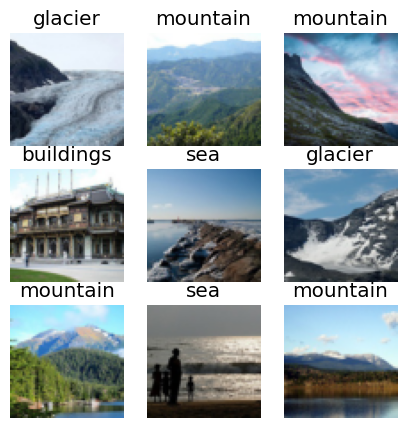

In [9]:
imageDls.train.show_batch(figsize=(5,5))

In [10]:
imageDls.vocab, imageDls.device

(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'],
 device(type='cuda', index=0))

### Input Shape

In [11]:
tensor(Image.open(get_image_files(path)[0])).shape

torch.Size([150, 150, 3])

### Batch Shape

In [16]:
xb, xy = first(imageDls.train)
xb.shape, xy.shape

(torch.Size([64, 3, 64, 64]), torch.Size([64]))

# Training

## Fitting Method

In [25]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, kernel_size = ks, stride=2, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [26]:
def simple_cnn():
    return sequential(
    conv(3, 8, ks=5), #31*31
    conv(8, 16),   #16*16
    conv(16, 32),  #8*8
    conv(32, 64),  #4*4
    conv(64, 128), #2*2
    conv(128, 6, act=False),  #1*1 
    Flatten()
)
    

In [27]:
from fastai.callback.hook import *
learn = Learner(imageDls, simple_cnn(), loss_func=F.cross_entropy,
                metrics=accuracy,cbs=ActivationStats(with_hist=True))

In [28]:
learn.summary()

Sequential (Input shape: 64 x 3 x 64 x 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 8 x 32 x 32    
Conv2d                                    608        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 16 x 16   
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 8 x 8     
Conv2d                                    4640       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 4 x 4     
Conv2d                                    18496      True      
ReLU                                          

In [29]:
learn.fit(2, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,1.250833,1.185517,0.554333,00:11
1,1.162781,1.174726,0.567333,00:11


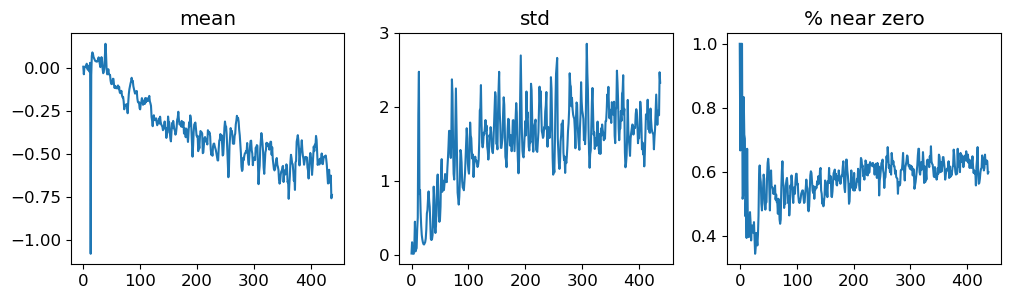

In [30]:
learn.activation_stats.plot_layer_stats(-1)

Terrible performance is observed

## Increasing training performance
### Fit one cycle

In [38]:
modelArch = simple_cnn()
def fit(epochs = 1):
    learnObject = Learner(imageDls, modelArch, loss_func=F.cross_entropy,
                    metrics=accuracy,cbs=ActivationStats(with_hist=True))
    learnObject.fit_one_cycle(epochs, 0.01)
    return learnObject

In [39]:
oneCycledLearner = fit(epochs = 10)

epoch,train_loss,valid_loss,accuracy,time
0,1.237066,1.177451,0.544000,00:12
1,1.082278,1.010555,0.581333,00:12
2,0.985077,1.084994,0.578333,00:12
3,0.881163,0.836318,0.675667,00:11
4,0.806970,0.830546,0.686000,00:11
5,0.699754,0.780435,0.706667,00:10
6,0.597874,0.751788,0.732333,00:14
7,0.489379,0.748709,0.734667,00:13
8,0.375274,0.798401,0.735000,00:17
9,0.325042,0.802716,0.732000,00:15


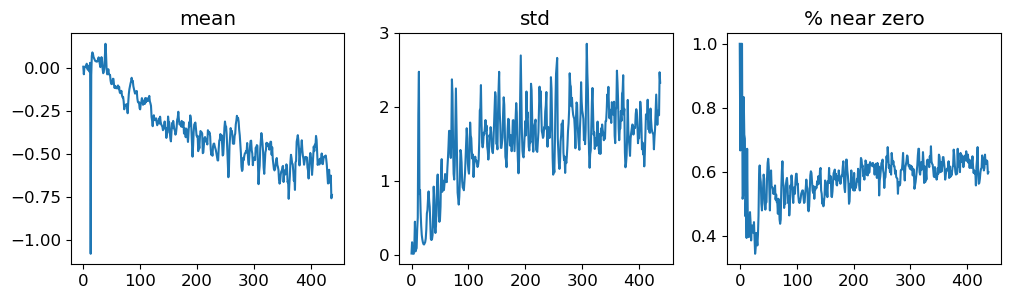

In [57]:
learn.activation_stats.plot_layer_stats(-1)

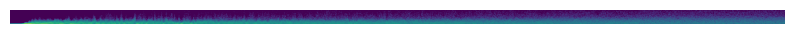

In [59]:
oneCycledLearner.activation_stats.color_dim(-1, figsize=(10,10))

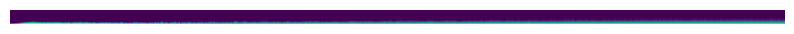

In [72]:
oneCycledLearner.activation_stats.color_dim(2, figsize=(10,10))

In [62]:
flatten_model(modelArch)

[Conv2d(3, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)),
 ReLU(),
 Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
 ReLU(),
 Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
 ReLU(),
 Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
 ReLU(),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
 ReLU(),
 Conv2d(128, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
 fastai.layers.Flatten(full=False)]

In [123]:
def visualize_training(model):
    stats = ActivationStats(with_hist=True)
    layers = [m for m in flatten_model(model) if has_params(m)]
    for i, layer in enumerate(layers):
        print(i, layer)
        fig, ax = plt.subplots(figsize=(10,20))
        ax.set_title(layer, fontsize = 8)
        model.activation_stats.color_dim(i, ax=ax, figsize=(5,10))

0 Conv2d(3, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
1 Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
2 Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
3 Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
4 Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
5 Conv2d(128, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))


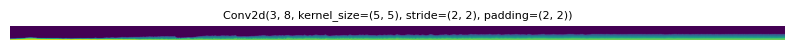

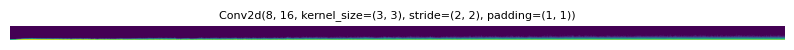

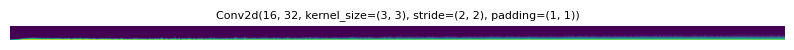

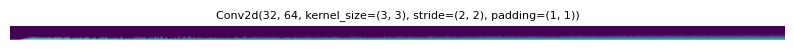

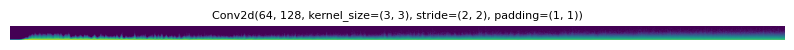

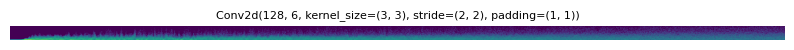

In [124]:
visualize_training(oneCycledLearner)

### Using larger batch size

In [129]:
def get_dls(bs=64):
    return DataBlock(blocks=(ImageBlock, CategoryBlock),
                     get_items=get_image_files, #get files recursively in the dataloader
                     splitter=GrandparentSplitter(train_name='seg_train', valid_name='seg_test'),
                     get_y = parent_label,
                     item_tfms=Resize(64)).dataloaders(path, bs=bs)

In [130]:
imageDls = get_dls(512)

In [131]:
# Batch Tensor
xb, yb = first(imageDls.train)
xb.shape, yb.shape

(torch.Size([512, 3, 64, 64]), torch.Size([512]))

In [132]:
# Learner with large batch and fit one cycle training
learnLargeBatch = fit(10)

/home/agastya/mambaforge/lib/python3.10/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.317684,0.832525,0.732333,00:13
1,0.322842,0.937174,0.715000,00:12
2,0.337197,0.936470,0.721000,00:13
3,0.307826,1.059739,0.720000,00:11
4,0.262555,1.139784,0.723667,00:14
5,0.213851,1.255443,0.711667,00:12
6,0.169578,1.372892,0.720000,00:09
7,0.130703,1.458602,0.725000,00:10
8,0.101895,1.489798,0.724667,00:09
9,0.082092,1.489403,0.727000,00:09


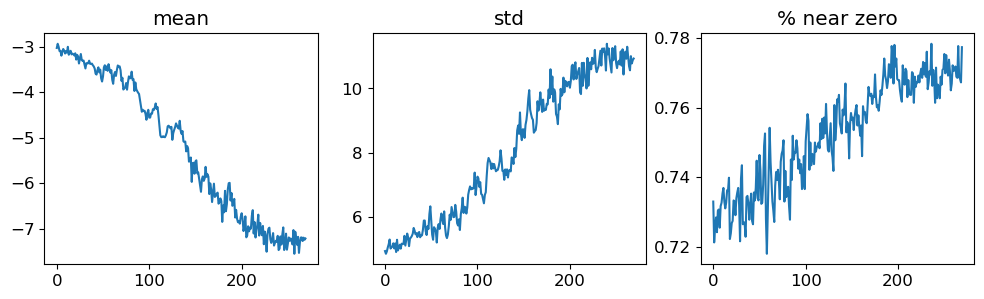

In [136]:
learnLargeBatch.activation_stats.plot_layer_stats(-1)

0 Conv2d(3, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
1 Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
2 Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
3 Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
4 Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
5 Conv2d(128, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))


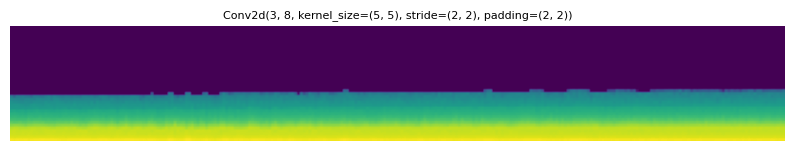

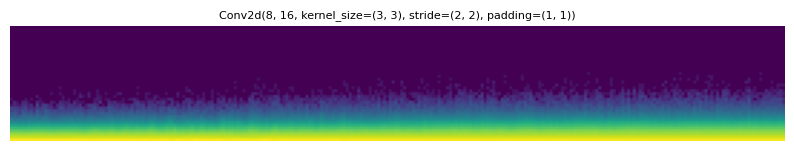

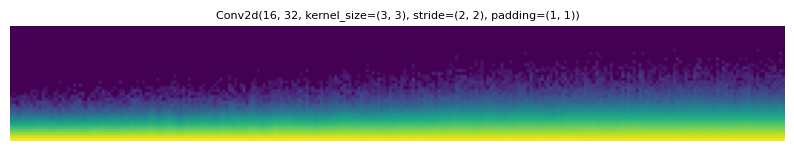

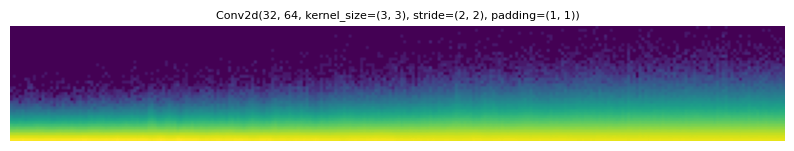

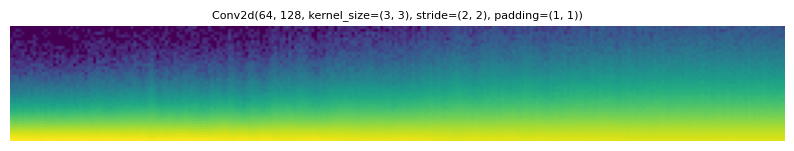

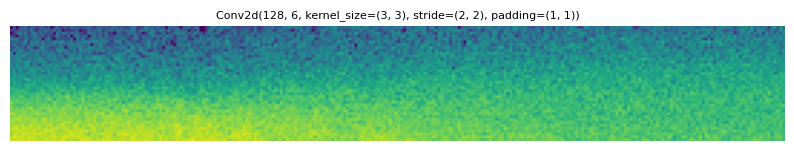

In [141]:
visualize_training(learnLargeBatch)

Training has improved 
- But model with large batch size is overfitting
- Model with small batch size has unstable gradients

## Adding batchNorm

In [182]:
def conv_batchArch(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, kernel_size=ks, stride=2, padding=ks//2)]
    if act: layers.append(nn.ReLU())
    layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)

In [183]:
def simple_cnn(conv=conv):
    return sequential(
    conv(3, 8, ks=5), #31*31
    conv(8, 16),   #16*16
    conv(16, 32),  #8*8
    conv(32, 64),  #4*4
    conv(64, 128), #2*2
    conv(128, 6, act=False),  #1*1 
    Flatten()
)

In [185]:
imageDls = get_dls(512)
batchedNormModel = simple_cnn(conv_batchArch)

In [187]:
# bs = 512
learnBatchNormed=Learner(imageDls, batchedNormModel, loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
learnBatchNormed.summary()

Sequential (Input shape: 512 x 3 x 64 x 64)
Layer (type)         Output Shape         Param #    Trainable 
                     512 x 8 x 32 x 32   
Conv2d                                    608        True      
ReLU                                                           
BatchNorm2d                               16         True      
____________________________________________________________________________
                     512 x 16 x 16 x 16  
Conv2d                                    1168       True      
ReLU                                                           
BatchNorm2d                               32         True      
____________________________________________________________________________
                     512 x 32 x 8 x 8    
Conv2d                                    4640       True      
ReLU                                                           
BatchNorm2d                               64         True      
____________________________________

In [189]:
learnBatchNormed.fit_one_cycle(10, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,1.267841,1.576738,0.359333,00:11
1,1.047378,1.293031,0.538000,00:11
2,0.911820,1.588868,0.428667,00:11
3,0.798525,2.078283,0.374000,00:11
4,0.694635,0.950070,0.658667,00:11
5,0.596290,0.690554,0.763333,00:11
6,0.495181,0.756273,0.738000,00:12
7,0.395955,0.697452,0.765667,00:11
8,0.310642,0.705006,0.760667,00:11
9,0.250171,0.685288,0.769333,00:12


0 Conv2d(3, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
1 BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2 Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
3 BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
4 Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
5 BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
6 Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
7 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
8 Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
9 BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
10 Conv2d(128, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
11 BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


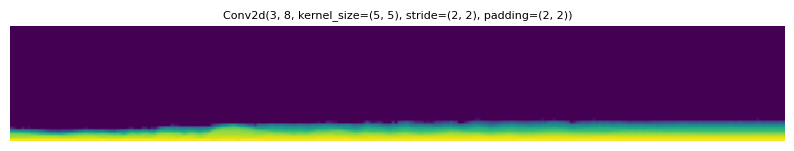

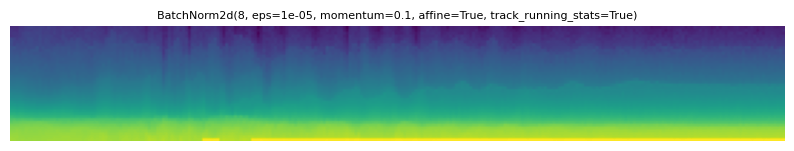

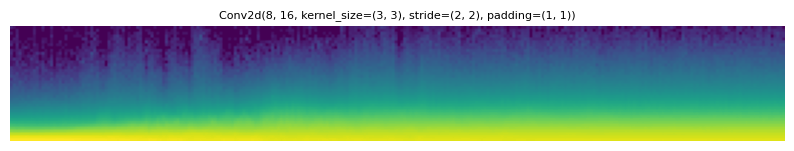

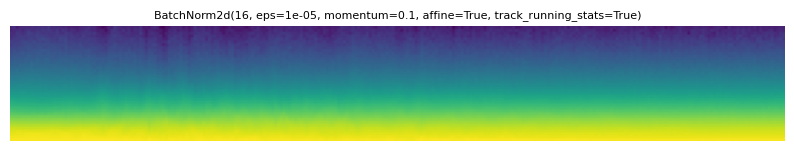

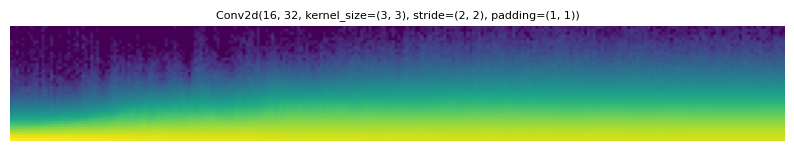

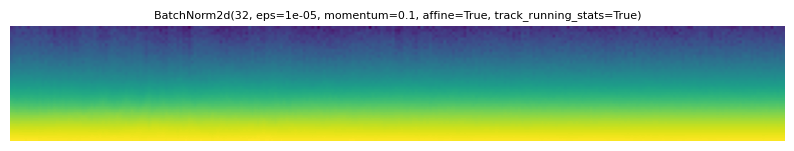

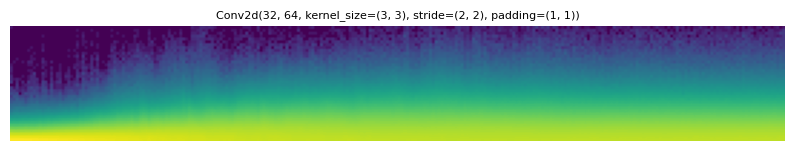

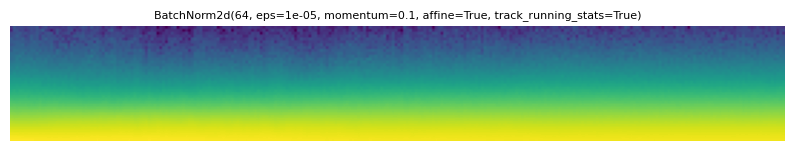

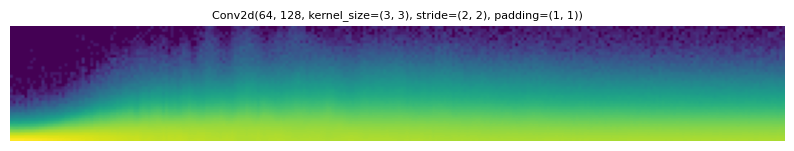

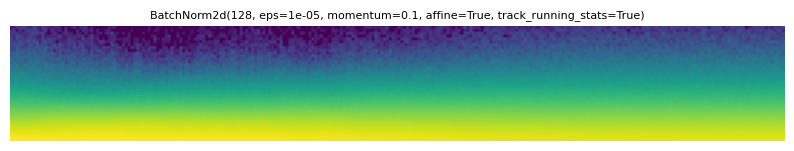

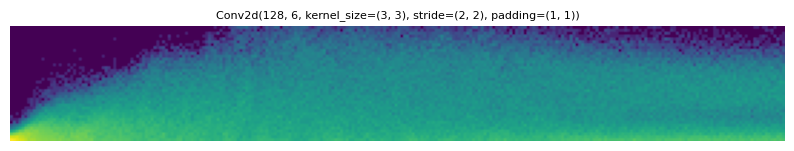

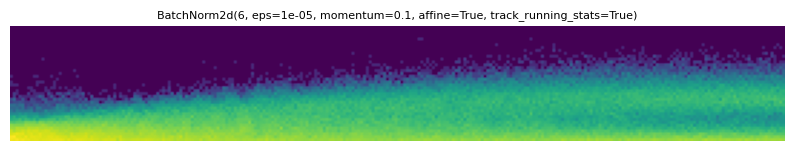

In [219]:
visualize_training(learnBatchNormed)

In [210]:
train_loss = [item[0] for item in learnBatchNormed.recorder.values]
valid_loss = [item[1] for item in learnBatchNormed.recorder.values]
accuracy = [item[2] for item in learnBatchNormed.recorder.values]

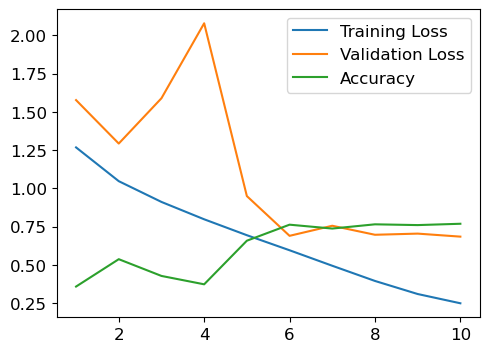

In [217]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, label=f'Training Loss')
plt.plot(epochs, valid_loss, label=f'Validation Loss')
plt.plot(epochs, accuracy, label=f'Accuracy')
plt.legend()

In [218]:
def visualize_training_epochs(learner):
    train_loss = [item[0] for item in learner.recorder.values]
    valid_loss = [item[1] for item in learner.recorder.values]
    accuracy = [item[2] for item in learner.recorder.values]
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs, train_loss, label=f'Training Loss')
    plt.plot(epochs, valid_loss, label=f'Validation Loss')
    plt.plot(epochs, accuracy, label=f'Accuracy')
    plt.legend()

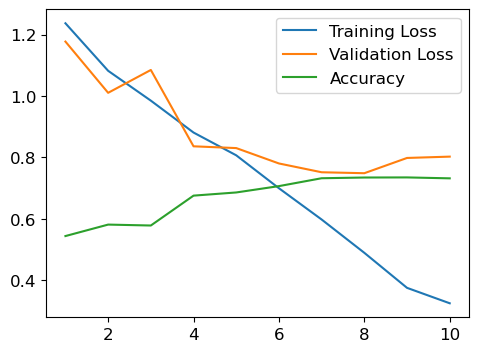

In [220]:
visualize_training_epochs(oneCycledLearner)

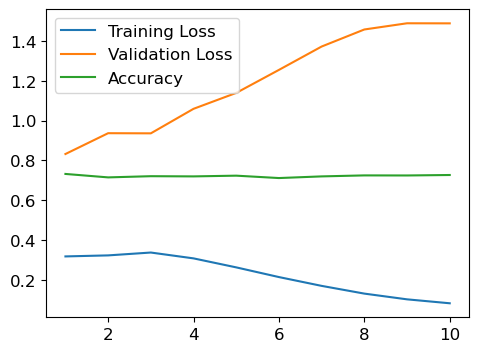

In [221]:
visualize_training_epochs(learnLargeBatch)

# Testing Inference

In [232]:
testImg = path/'seg_pred'
testImg = get_image_files(testImg)
testImg[0]

Path('intel-image-classification/seg_pred/seg_pred/15053.jpg')

In [237]:
img = Image.open(testImg[0])
img = img.resize((64, 64))

In [224]:
infernces = [learn, oneCycledLearner, learnLargeBatch, learnBatchNormed]

In [244]:
learn.dls.vocab

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [245]:
learn.predict(img)

("['buildings', 'street', 'buildings', 'buildings', 'buildings', 'buildings']",
 tensor([ 0.2220, -1.1535,  0.0617, -0.8917,  0.3807, -0.2079]),
 tensor([ 0.2220, -1.1535,  0.0617, -0.8917,  0.3807, -0.2079]))

In [246]:
oneCycledLearner.predict(img)

IndexError: list index out of range

In [ ]:
for l in infernces:
    l.predict(img)